In [1]:
import re

bfs_file = "/Users/sakshmenon/Desktop/PLM/Workflow Gen/Similarity Search/s_cerevisiae2s_pombe.bfs.k30.txt"

def extract_query_and_matches(text):
    text = text.split('\n')[:-1]
    query = text[0].split('\t')[1:]
    top_matches = text[1:]

    return {
        "Query": query,
        "Matches": [{"Score": match.split('\t')[1], "Protein ID": match.split('\t')[2][1:]} for match in top_matches]
    }

match_list = []
with open(bfs_file) as file_obj:
    content = file_obj.read()
    queries = content.split('\n\n')
    for query in queries[1:-1]:
        result = extract_query_and_matches(query)
        match_list.append(result)


/var/folders/h3/pl4_4z116_dcntldrzwpn49w0000gn/T/ipykernel_50640/1170984875.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, color='purple', ax=axes[0])


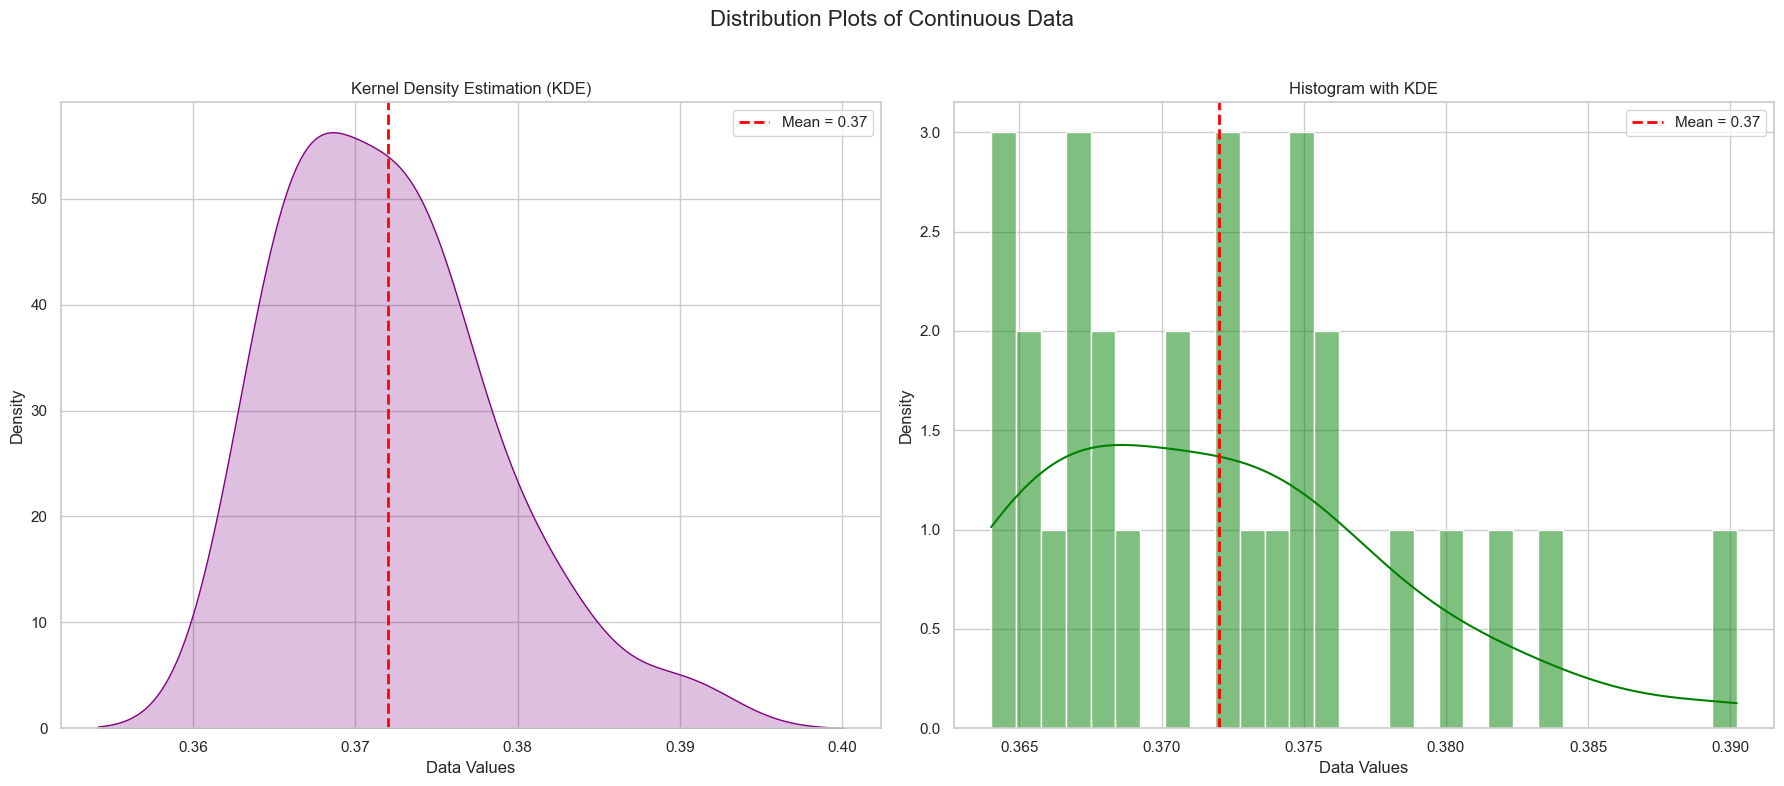

In [108]:
import numpy as np
import scipy.stats as stats

scores = [float(match['Score']) for match in match_list[0]['Matches']]
max_val = max(scores)
# scores = [score/max_val for score in scores]

scores_diff = [(scores[0]/i) for i in scores[1:]]

mean_score = np.mean(scores_diff)
std_score = np.std(scores_diff)

# Calculate the z-scores for each score
z_scores = [(score - mean_score) / std_score for score in scores_diff]
# p_value = 2 * (1 - stats.norm.cdf(abs(z_scores[0])))
p_value = 1 - stats.norm.cdf(z_scores[0])
# print(p_value)
plot_distribution(scores_diff)

In [109]:
# scores_diff
# z_scores
p_value

0.0020871030729217033

In [120]:
def compute_score_differences(query_list, num_matches):
    result = []
    p_scores = []
    z_scores_all = []
    
    for query in query_list:
        query_id = query['Query']
        matches = query['Matches']

        scores = [float(match['Score']) for match in matches[:num_matches+1]]
        
        # Extract the top match score
        scores = [float(match['Score']) for match in matches]
        top1_score = scores[0]
        top2_score = scores[1]
        max_val = max(scores)

        scores_diff = [(scores[0]/i) for i in scores[1:]]

        mean_score = np.mean(scores_diff)
        std_score = np.std(scores_diff)

        # Calculate the z-scores for each score
        z_scores = [(score - mean_score) / std_score for score in scores_diff]
        p_value = 1 - stats.norm.cdf(z_scores[0])
        # p_value = 2 * (1 - stats.norm.cdf(abs(z_scores[0])))
        # p_value = 1 - stats.norm.cdf(z_scores[0])
        z_scores_all.append(z_scores[0])
        p_scores.append(p_value)
        
        p_id = matches[0]['Protein ID']

        # Compute the difference for the given number of matches
        placeholder = {query_id[0] : {
            "Top Protein ID": p_id,
            "Top Score": top1_score,
            "Normalized Top Score": scores[0]}
        }

        placeholder[query_id[0]]["Match 2 Score"] = top2_score
        placeholder[query_id[0]]["Match 2 Protein ID"] = matches[1]['Protein ID']
        placeholder[query_id[0]]["Z Score"] = z_scores[0]

        placeholder[query_id[0]]["Confidence Score (%)"] = p_value
        
        result.append(placeholder)

    ranks = [[[*result[res].values()][0]['Confidence Score (%)'], res] for res in range(0, len(result))]
    sorted_values = []
    ranks.sort()
    # ranks.reverse()
    for rank in ranks:
        sorted_values.append(result[rank[1]])

    return sorted_values, ranks, z_scores_all

# Compute differences for the top 3 matches
num_matches_to_compare = 1
result, ranks, z_scores = compute_score_differences(match_list, num_matches_to_compare)

TypeError: unhashable type: 'list'

In [75]:
import json

# all queries

json_object = json.dumps(result, indent=4)

with open("score_gap_z_score_all.json", "w") as outfile:
	outfile.write(json_object)

# 30 sampled queries

sampled_results = result[:10] + result[int(len(result)/2) : int(len(result)/2) + 10]+ result[-10:]

json_object = json.dumps(sampled_results, indent=4)

with open("score_gap_z_score_sampled.json", "w") as outfile:
	outfile.write(json_object)

/var/folders/h3/pl4_4z116_dcntldrzwpn49w0000gn/T/ipykernel_50640/1170984875.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, color='purple', ax=axes[0])


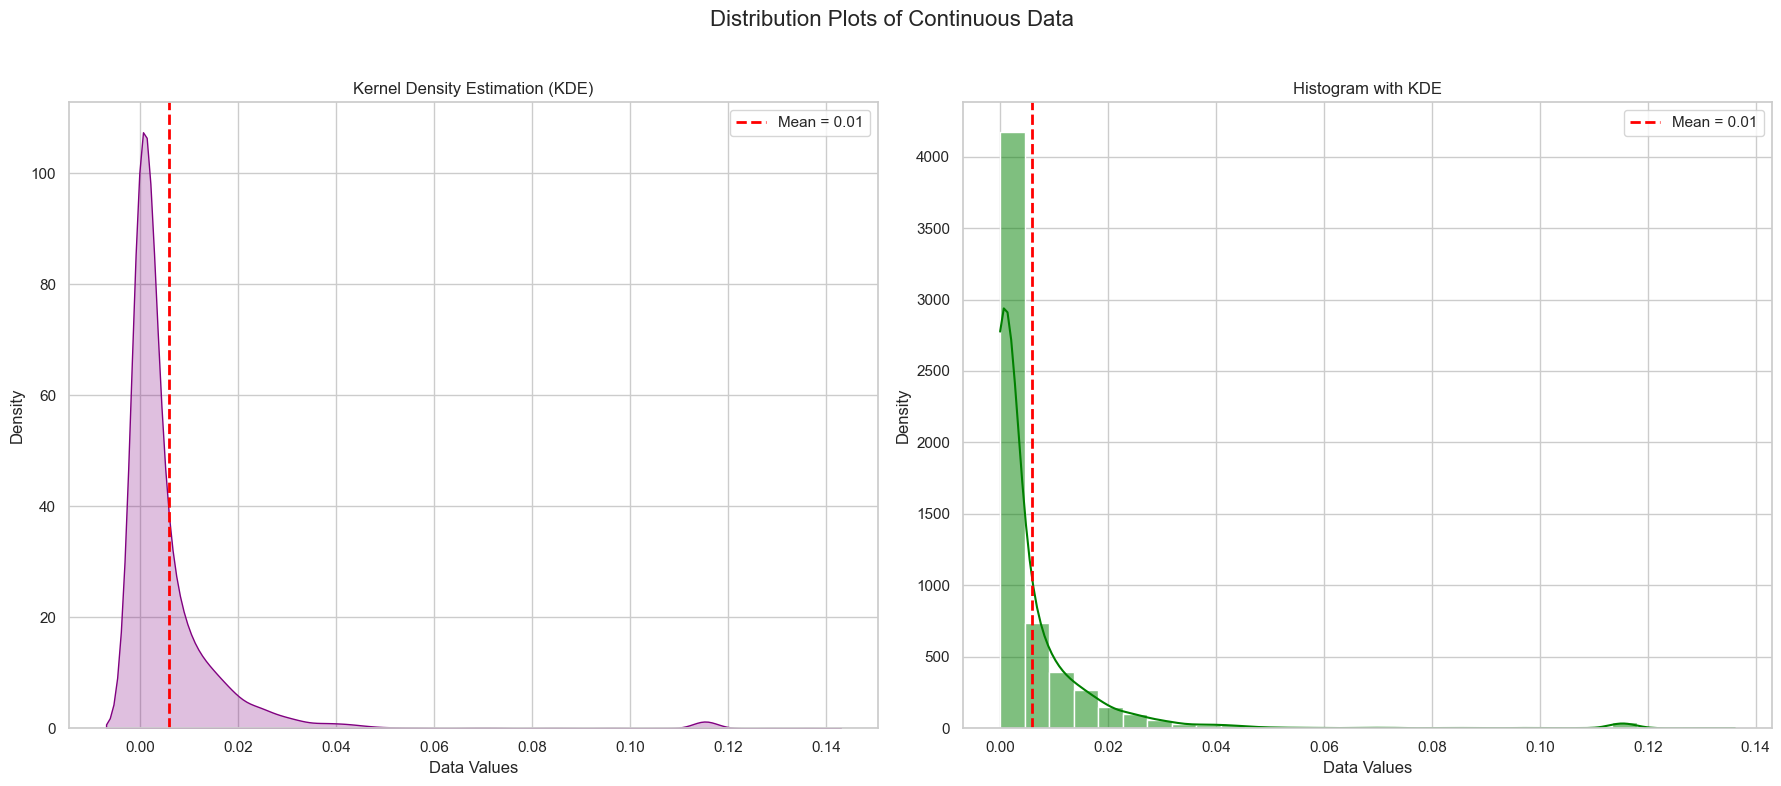

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generate some sample continuous data
np.random.seed(42)
data = np.random.normal(loc=0, scale=1, size=500)  # Normally distributed data

def plot_distribution(data):
    mean = sum(data)/len(data)
    # Set the style for better aesthetics
    sns.set(style="whitegrid")

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # KDE Plot
    sns.kdeplot(data, shade=True, color='purple', ax=axes[0])
    axes[0].set_title('Kernel Density Estimation (KDE)')
    axes[0].set_xlabel('Data Values')
    axes[0].set_ylabel('Density')

    axes[0].axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}')
    axes[0].legend()

    # Histogram with KDE overlay
    sns.histplot(data, bins=30, kde=True, color='green', ax=axes[1])
    axes[1].set_title('Histogram with KDE')
    axes[1].set_xlabel('Data Values')
    axes[1].set_ylabel('Density')

    axes[1].axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}')
    axes[1].legend()

    # Display the plots
    plt.suptitle('Distribution Plots of Continuous Data', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()

# Call the function to create and display the plots
data = [i[0] for i in ranks]
plot_distribution(data)


/var/folders/h3/pl4_4z116_dcntldrzwpn49w0000gn/T/ipykernel_50640/1170984875.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True, color='purple', ax=axes[0])


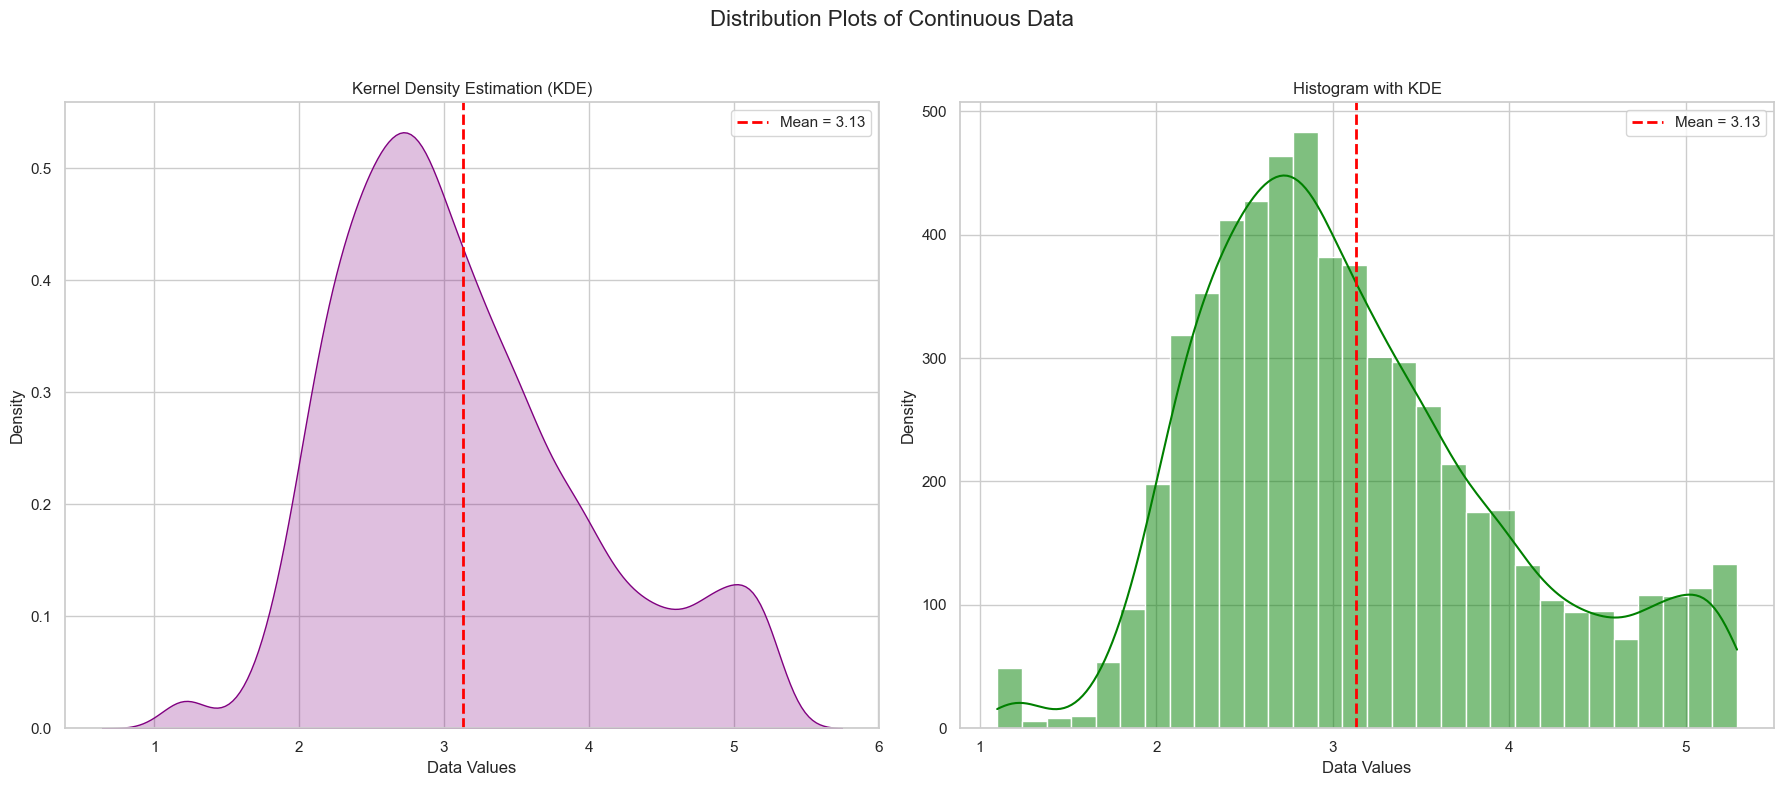

In [112]:
# data = [[*i.values()][0]['Normalized Top Score'] for i in result]
plot_distribution(z_scores)

In [148]:
rank_list = []
for res in range(0, len(result)):
    ref = [*result[res].values()][0]
    q_id = [*result[res].keys()][0]
    z_score = ref['Z Score']
    m1_id = ref['Top Protein ID']
    m1_s = ref['Top Score']
    m2_id = ref['Match 2 Protein ID']
    m2_s = ref['Match 2 Score']
    rank_list.append([z_score, q_id, m1_id, m1_s, m2_id, m2_s])

rank_list.sort()
rank_list

[[1.097820313780935,
  '>NP_058179.1 gag protein [Saccharomyces cerevisiae S288C]',
  'NP_596814.1 SIN component scaffold protein Sid4 [Schizosaccharomyces pombe]',
  1.241,
  'NP_001417984.1 LOW QUALITY PROTEIN: retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]',
  1.285],
 [1.1308543517185856,
  '>NP_058134.1 gag protein [Saccharomyces cerevisiae S288C]',
  'NP_001417984.1 LOW QUALITY PROTEIN: retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]',
  1.125,
  'NP_001417963.1 LOW QUALITY PROTEIN: retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]',
  1.129],
 [1.1848157145223555,
  '>NP_058146.3 gag-pol fusion protein [Saccharomyces cerevisiae S288C]',
  'NP_001417984.1 LOW QUALITY PROTEIN: retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]',
  0.902,
  'NP_593984.1 retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]',
  0.907],
 [1.1881004081168525,
  '>NP_058142.3 gag-pol 

here are the 3 of the worsst ones:

Entry 1:

    Query Protein: NP_058179.1 gag protein [Saccharomyces cerevisiae S288C]

    Zscore: 1.09782

    Top 1 Match Protein ID: NP_596814.1 SIN component scaffold protein Sid4 [Schizosaccharomyces pombe]
    Top 1 Match Gap Score: 1.241

    Top 2 Match Protein ID: NP_001417984.1 LOW QUALITY PROTEIN: retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]
    Top 2 Match Gap Score: 1.285

Entry 2:

    Query Protein:NP_058134.1 gag protein [Saccharomyces cerevisiae S288C]

    Zscore: 1.13085

    Top 1 Match Protein ID: NP_001417984.1 LOW QUALITY PROTEIN: retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]
    Top 1 Match Gap Score: 1.125

    Top 2 Match Protein ID: NP_001417963.1 LOW QUALITY PROTEIN: retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]
    Top 2 Match Gap Score: 1.129

Entry 3:

    Query Protein: NP_058146.3 gag-pol fusion protein [Saccharomyces cerevisiae S288C]

    Zscore: 1.18481

    Top 1 Match Protein ID: NP_001417984.1 LOW QUALITY PROTEIN: retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]
    Top 1 Match Gap Score: 0.902

    Top 2 Match Protein ID: NP_593984.1 retrotransposable element/transposon Tf2-type [Schizosaccharomyces pombe]
    Top 2 Match Gap Score: 0.907
